# Импорт библиотек

In [2]:
from tqdm.notebook import tqdm
%matplotlib inline

from torchvision import datasets, transforms


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from scipy.optimize import minimize
from sklearn.metrics import accuracy_score, f1_score 
from functools import partial 
from tqdm import tqdm

import torch
import torch.nn as nn

# Загрузка данных

In [ ]:
!pip install kaggle

In [5]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 71 bytes


In [6]:
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes         62           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes        105           False  
store-sales-time-series-forecasting            2030-06-30 23:59:00  Getting Started  Knowledge        853           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        166           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       1817           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      13948           False  
house-pr

In [7]:
!kaggle datasets download -d andrewmvd/animal-faces

 99% 692M/696M [00:05<00:00, 188MB/s]
100% 696M/696M [00:05<00:00, 129MB/s]


In [ ]:
!unzip animal-faces.zip

In [9]:
# посмотрим на картинки

In [10]:
import os

In [11]:
! ls

afhq  animal-faces.zip	sample_data


In [12]:
folder = []
for i in os.walk('afhq'):
  folder.append(i)

In [13]:
folder[0]

('afhq', ['train', 'val'], [])

In [ ]:
for address, dirs, files in folder:
  for file in files:
    print(address+'/'+file)

In [15]:
from PIL import Image
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


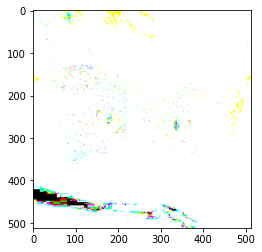

In [16]:
img = np.asarray(Image.open('afhq/train/cat/pixabay_cat_000667.jpg'))
plt.imshow(img_to_array(img))

In [17]:
# нужно привести изображения к единому формату

In [18]:
#приведем все изображения к единому формату, конвертируем в торч тензор и нормализовуем
transform_train = transforms.Compose([
         transforms.Resize((224, 224)),
         transforms.ToTensor()
])
# отдельный для теста
transform_val = transforms.Compose([
         transforms.Resize((224, 224)),                           
         transforms.ToTensor()
])

In [19]:
# загрузка и предобработка
train_data = datasets.ImageFolder("afhq/train/", transform=transform_train, )
test_data = datasets.ImageFolder("afhq/val", transform=transform_val)

In [20]:
train_data

Dataset ImageFolder
    Number of datapoints: 14630
    Root location: afhq/train/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [21]:
# разбиваем на батчи (обычно берут под максимум, который влезает в память)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle = True, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle = False, pin_memory=True, num_workers=2)

In [56]:
test_loader

In [22]:
dataiter = iter(train_loader)
# батч картинок и батч ответов к картинкам
images, labels = dataiter.next()

In [57]:
labels

tensor([0, 2, 2, 0, 2, 2, 1, 1, 0, 0, 2, 0, 1, 2, 0, 0])

In [23]:
# размер картинок 
images.shape, labels.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16]))

In [24]:
#видим достаточно большое разрешение - простые сети могут выдать не очень хорошее качество

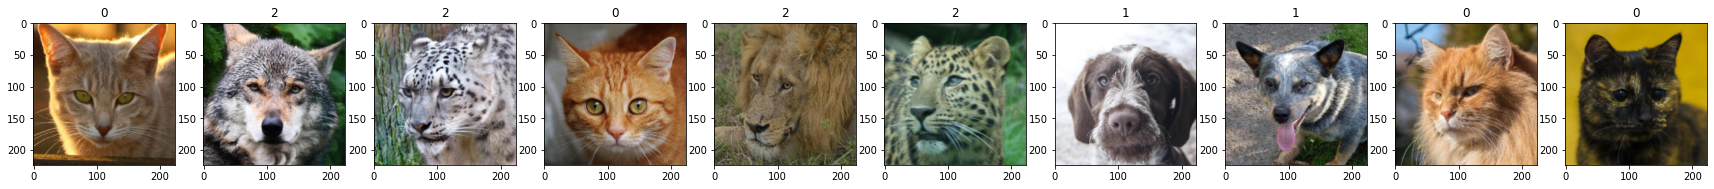

In [25]:
# посмотрим на картинки
def show_imgs(imgs, labels):
    f, axes= plt.subplots(1, 10, figsize=(30,5))
    for i, axis in enumerate(axes):
      axes[i].imshow(np.squeeze(np.transpose(imgs[i].numpy(), (1, 2, 0))), cmap='gray')
      axes[i].set_title(labels[i].numpy())
    plt.show()

show_imgs(images, labels)

In [26]:
# видим три класса: кошки, собаки и дикие животные

# Обучение базовой сети

In [27]:
# код обучения сети

In [28]:
from tqdm.notebook import tqdm

In [29]:
# модуль, где определены слои для нейронных сетей
import torch.nn as nn
# модуль, где определены активации для слоев нейронных сетей
import torch.nn.functional as F

In [47]:
def train(net, n_epoch=2):
    # выбираем функцию потерь
    loss_fn = torch.nn.CrossEntropyLoss()

    # выбираем алгоритм оптимизации и learning_rate
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    # acc по test
    best_accuracy = 0
    # обучаем сеть 2 эпохи
    for epoch in tqdm(range(n_epoch)):

        running_loss = 0.0
        train_dataiter = iter(train_loader)
        for i, batch in enumerate(tqdm(train_dataiter)):
            # так получаем текущий батч
            X_batch, y_batch = batch
            
            # обнуляем градиент
            optimizer.zero_grad()

            # forward pass (получение ответов на батч картинок)
            y_pred = net(X_batch)
            # вычисление лосса от выданных сетью ответов и правильных ответов на батч
            loss = loss_fn(y_pred, y_batch)
            # bаckpropagation (вычисление градиентов)
            loss.backward()
            # обновление весов сети
            optimizer.step()
            
            # проверяем качество каждые 1500 батчей (~пол эпохи)
            if i % 1500 ==0:
                # менеджер упарвления контекстом торча указывает на то, чтобы не обновлять параметры
                with torch.no_grad():
                    accuracy = []
                    for batch in test_loader:
                        x, y = batch
                        y_pred = net(x)
                        # loss = loss_fn(y_pred, y)
                        # находим accuracy батча с теста
                        accuracy.append(accuracy_score(y.detach().numpy(), np.argmax(y_pred.detach().numpy(), axis=1)))
                    # усредняем accuracy всех батчей на тесте
                    accuracy = np.mean(np.array(accuracy))
                    # если стало лучше - сохраняем на диск и обновляем лучшую метрику
                    if accuracy > best_accuracy:
                        print('New best model with test acc:', accuracy)
                        torch.save(net.state_dict(), './best_model.pt')
                        best_accuracy = accuracy

            # выведем текущий loss
            running_loss += loss.item()
            # выведем качество каждые 500 батчей
            if i % 500 == 499:
                print('[%d, %5d] loss: %.3f' %
                        (epoch + 1, i + 1, running_loss / 500))
                running_loss = 0.0

    print('Обучение закончено')
    return net

In [31]:
# начнем работу с простой двуслойной полносвязной нс, обучим ее и посчитаем метрику accuracy на тестовой выборке:

In [32]:
# класс для удобного перевода картинки из двумерного объекта в вектор
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [33]:
# класс для удобного перевода картинки из двумерного объекта в вектор
class ам(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = Flatten()
        # self.fc1 = nn.Linear(3*512*512, 32*32) # полносвязные слои - вход и выход
        # self.fc2 = nn.Linear(32*32, 3)
        self.fc1 = nn.Linear(3 * 224 * 224, 16*16) # полносвязные слои - вход и выход
        self.fc2 = nn.Linear(16*16, 3)
    
    def forward(self, x):
        # forward pass сети

        # переводим входной объект из картинки в вектор
        x = self.flatten(x)
        # умножение на матрицу весов 1 слоя и применение функции активации
        x = F.relu(self.fc1(x))
        # умножение на матрицу весов 2 слоя и применение функции активации
        x = F.softmax(self.fc2(x), dim=1)
        return x

In [ ]:
# размер картинок пришлось сделать 224 * 224, а размер батча 16 - иначе не хватает ОЗУ 

In [36]:
# объявляем сеть
net = SimpleNet()
# обучаем сеть
net = train(net)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/915 [00:00<?, ?it/s]

New best model with test acc: 0.3324468085106383
[1,   500] loss: 1.230


  0%|          | 0/915 [00:00<?, ?it/s]

[2,   500] loss: 1.227
Обучение закончено


In [37]:
# посмотрим лучшую модель
model = SimpleNet()
model.load_state_dict(torch.load('./best_model.pt'))
model.eval()

SimpleNet(
  (flatten): Flatten()
  (fc1): Linear(in_features=150528, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=3, bias=True)
)

In [38]:
# посмотрим accuracy на тесте
with torch.no_grad():
    accuracy = []
    for batch in test_loader:
        x, y = batch
        y_pred = net(x)
        accuracy.append(accuracy_score(y.numpy(), np.argmax(y_pred.detach().numpy(), axis=1)))
    accuracy = np.mean(np.array(accuracy))

print('accuracy', accuracy)

accuracy 0.3324468085106383


In [ ]:
#accuracy как и ожидалось получился низкий для простой полносвязной сети

# Обучение сверточной сети

In [48]:
# попробуем сверточную сеть с двумя сверточными и одним полносвязным соями

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 20, kernel_size=3)
        self.conv2 = nn.Conv2d(20, 3, kernel_size=3) 
        self.flatten = Flatten()
        self.fc = nn.Linear(145200, 3) # какой тут будет размер входа? не всегда очевидно, особенно когда слоев много и этапов много, пробуйте выводить x.size() при прямом проходе
    
    def forward(self, x):
        # forward pass сети
        # умножение на матрицу весов 1 слоя и применение функции активации
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.flatten(x)
        # print(x.size())
        # умножение на матрицу весов 2 слоя и применение функции активации
        x = F.softmax(self.fc(x), dim=1)
        # print(x.shape)
        return x

In [49]:
net = ConvNet()
net = train(net)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/915 [00:00<?, ?it/s]

New best model with test acc: 0.331781914893617
[1,   500] loss: 0.912


  0%|          | 0/915 [00:00<?, ?it/s]

New best model with test acc: 0.8091755319148937
[2,   500] loss: 0.718
Обучение закончено


In [50]:
# проверяем по метрикам
with torch.no_grad():
    accuracy = []
    for batch in test_loader:
        x, y = batch
        real = y
        y_pred = net(x)
        y_pred_best_model = net(x)
        accuracy.append(accuracy_score(y.numpy(), np.argmax(y_pred.detach().numpy(), axis=1)))
    accuracy = np.mean(np.array(accuracy))

print('accuracy', accuracy)

accuracy 0.7890070921985816


In [ ]:
#accuracy для простой сверточной сети получился уже довольно высоким, пробуем дальше

# Переносим сеть на CUDA

In [40]:
device = torch.device('cuda')

In [41]:
torch.cuda.is_available()

True

In [42]:
torch.cuda.get_device_name()

'Tesla K80'

In [43]:
def train(net, n_epoch=2):
    # выбираем функцию потерь
    loss_fn = torch.nn.CrossEntropyLoss()

    # выбираем алгоритм оптимизации и learning_rate
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    # acc по test
    best_accuracy = 0
    # обучаем сеть 2 эпохи
    for epoch in tqdm(range(n_epoch)):

        running_loss = 0.0
        train_dataiter = iter(train_loader)
        for i, batch in enumerate(tqdm(train_dataiter)):
            # так получаем текущий батч
            X_batch, y_batch = batch
            # переносим его на видеопамять
            # если точно уверены, что это гпу - можно написать .cuda()
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            # обнуляем веса
            optimizer.zero_grad()

            # forward pass (получение ответов на батч картинок)
            y_pred = net(X_batch)
            # вычисление лосса от выданных сетью ответов и правильных ответов на батч
            loss = loss_fn(y_pred, y_batch)
            # bsckpropagation (вычисление градиентов)
            loss.backward()
            # обновление весов сети
            optimizer.step()

            # проверяем качество каждые 1500 батчей (~пол эпохи)
            if i % 1500 ==0:
                # менеджер упарвления контекстом торча указывает на то, чтобы не обновлять параметры
                with torch.no_grad():
                    accuracy = []
                    for batch in test_loader:
                        x, y = batch
                        # переносим на гпу
                        x = x.to(device)
                        y = y.to(device)
                        # прогнозируем
                        y_pred = net(x)
                        # loss = loss_fn(y_pred, y)
                        # находим accuracy батча с теста
                        accuracy.append(accuracy_score(y.detach().cpu().numpy(), np.argmax(y_pred.detach().cpu().numpy(), axis=1)))
                    # усредняем accuracy всех батчей на тесте
                    accuracy = np.mean(np.array(accuracy))
                    # если стало лучше - сохраняем на диск и обновляем лучшую метрику
                    if accuracy > best_accuracy:
                        print('New best model with test acc:', accuracy)
                        torch.save(net.state_dict(), './best_model.pt')
                        best_accuracy = accuracy

            # выведем текущий loss
            running_loss += loss.item()
            # выведем качество каждые 500 батчей
            if i % 500 == 499:
                print('[%d, %5d] loss: %.3f' %
                        (epoch + 1, i + 1, running_loss / 500))
                running_loss = 0.0

    print('Обучение закончено')
    return net

In [ ]:
# инициализируем сеть на видеокарте
net = ConvNet().to(device)
# обучаем
net = train(net, n_epoch=3)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/915 [00:00<?, ?it/s]

New best model with test acc: 0.3324468085106383
[1,   500] loss: 1.098


  0%|          | 0/915 [00:00<?, ?it/s]

[2,   500] loss: 1.098


  0%|          | 0/915 [00:00<?, ?it/s]

[3,   500] loss: 1.098
Обучение закончено


# Добавляем блоки свёртки и пулинга/ dropout/нициализацию Xavier

In [ ]:
class Conv3Pool1_Sum(nn.Module):
    """ Блок свёртки и пулинга со skip-connection и сложением на конце"""
    def __init__(self, in_c, out_c, kernel=3, pad=1, norm=False):
        super().__init__()
        self.conv1 = nn.Sequential(
                      nn.Conv2d( in_channels=in_c,
                                out_channels=out_c,
                                kernel_size=kernel,
                                padding=pad),    # вход 256, 256
                      nn.LeakyReLU(), 
                      )               
        self.bn1 = None
        if norm:
            self.bn1 = nn.BatchNorm2d(out_c) 
        self.conv2 = nn.Sequential(                          
                      nn.Conv2d( in_channels=out_c, out_channels=out_c, kernel_size=kernel, padding=pad),    
                      nn.LeakyReLU(), 
                      # nn.BatchNorm2d(out_c)
                      )         
        self.conv3 = nn.Sequential(                          
                      nn.Conv2d( in_channels=out_c, out_channels=out_c, kernel_size=kernel, padding=pad),    
                      nn.LeakyReLU(), 
                      # nn.BatchNorm2d(out_c)
                      )         
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.init_weights()


    def init_weights(self):
        for l in [self.conv1, self.conv2, self.conv3]:
            # He инициализация весов из нормального распределения
            # по-умолчанию используется Xavier инициализация
            torch.nn.init.kaiming_normal_(l[0].weight, a=0.01, mode='fan_in', nonlinearity='leaky_relu')  # a -- коэффициент определяющий наклон левой части ReLU

    def forward(self, x):
        x1 = self.conv1(x)
        if self.bn1:
            x1 = self.bn1(x1)
        x  = self.conv2(x1)
        x2 = self.conv3(x)
        x = x1 + x2
        x = self.pool1(x)
        return x

In [ ]:
class CNN(nn.Module):
    """Сеть с skip-connection и конкатенацией внутри отдельных блоков"""
    def __init__(self, n_classes):
        super().__init__()
        # self.conv1 = Conv3Pool1_Sum(3,   32)                                             # 128
        # self.conv2 = Conv3Pool1_Sum(32,  64)                                             # 64
        # self.conv3 = Conv3Pool1_Sum(64,  128)                                             # 32
        # self.conv4 = Conv3Pool1_Sum(128, 128, norm=True)                                 # 16
        self.conv1 = Conv3Pool1_Sum(3,   28)                                             
        self.conv2 = Conv3Pool1_Sum(28,  56)                                             
        self.conv3 = Conv3Pool1_Sum(56,  112)                                             
        self.conv4 = Conv3Pool1_Sum(112, 112, norm=True)                                  

        # (torch.Size([16, 3, 224, 224]), torch.Size([16]))
        # (torch.Size([16, 3, 32, 32]), torch.Size([16]))
        
        # self.fc1 = nn.Linear(32*32*3, 256) # полносвязные слои - вход и выход
        # self.fc2 = nn.Linear(256, 10)

        # self.fc1 = nn.Linear(3 * 224 * 224, 16*16) # полносвязные слои - вход и выход
        # self.fc2 = nn.Linear(16*16, 3)


        self.fc1 = nn.Sequential(            
                      nn.Linear(in_features=21952, out_features=21952/2, ),
                      nn.Dropout(0.2),
                      nn.LeakyReLU())
        # self.fc2 = nn.Sequential(            
        #               nn.Linear(in_features=512, out_features=64),
        #               nn.LeakyReLU())
        self.fc2_bn =  nn.BatchNorm1d(21952/2)
        self.out = nn.Sequential(            
                      nn.Linear(in_features=21952/2, out_features=n_classes),
                      # nn.SoftMax()
                                          )
        self.init_weights()
                          
    
    def init_weights(self):
        for l in [self.fc1, self.out]:
            # He инициализация весов из нормального распределения
            # по-умолчанию используется Xavier инициализация
            torch.nn.init.kaiming_normal_(l[0].weight, a=0.01, mode='fan_in', nonlinearity='leaky_relu')  # a -- коэффициент определяющий наклон левой части ReLU

    def forward(self, x):
        # x = x.view(x.shape[0], 1, 224, 224 )
        x = self.conv1(x)
        print(x.size())
        x = self.conv2(x)
        print(x.size())
        x = self.conv3(x)
        print(x.size())
        x = self.conv4(x)
        print(x.size())
        x = torch.flatten(x, 1)
        print(x.size())
        x = self.fc1(x)
        # x = self.fc2(x)
        # if self.training: 
        x = self.fc2_bn(x)   # иначе бачнорм на одном объекте упадёт на инференсе
        x = self.out(x)
        return x

In [ ]:
# torch.Size([16, 3, 32, 32]) #
# torch.Size([16, 32, 16, 16])
# torch.Size([16, 64, 8, 8])
# torch.Size([16, 128, 4, 4])
# torch.Size([16, 128, 2, 2])

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()


cnn = CNN(3).to(device)

In [ ]:
params_n = sum(p.numel() for p in cnn.parameters() if p.requires_grad)

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(cnn.parameters(), lr=1e-5)

In [1]:
# net = train(cnn, n_epoch=3)

In [ ]:
with torch.no_grad():
    accuracy = []
    for batch in test_loader:
        x, y = batch
        # переносим на гпу
        x = x.to(device)
        y = y.to(device)
        # прогнозируем
        y_pred = net(x)
        # loss = loss_fn(y_pred, y)
        # находим accuracy батча с теста
        accuracy.append(accuracy_score(y.detach().cpu().numpy(), np.argmax(y_pred.detach().cpu().numpy(), axis=1)))
    # усредняем accuracy всех батчей на тесте
    accuracy = np.mean(np.array(accuracy))

print('Test accuracy', accuracy)

In [ ]:
# для загрузки сохранения используем такой варинат сохранения - лучше рабоатет между cpu/gpu
# почистим кеш
torch.cuda.empty_cache()
import gc
gc.collect()

# загрузим модель (на деле лучше сохранять ту, которую на валидации выдавала результаты лучше, для этого следует испльзовать with torch.no_grad(): ... код для валидационного прогона)
cnn_loaded = CNN(10).to(device)
cnn_loaded.load_state_dict(torch.load('best_model.pt'))
cnn_loaded.eval()

In [ ]:
# выведем результаты лучшей по accuracy  сети - сверточной ConvNet

In [114]:
from sklearn.metrics import classification_report

# результат предсказания лучшей сети ConvNet по другим метрикам

y_pred_list = []
y_test=[]
with torch.no_grad():
    accuracy = []
    for batch in test_loader:
        x, y = batch
        y_pred = net(x)
        y_test.append(y.numpy())
        y_pred_list.append(np.argmax(y_pred.detach().numpy(), axis=1))

In [115]:
y_pred_list_ = [a.squeeze().tolist() for a in y_pred_list]
# y_pred_list

In [116]:
y_test_ = [a.squeeze().tolist() for a in y_test]

In [118]:
y_test__ = np.array(y_test,dtype=object)

In [160]:
print(classification_report(y_test_res,y_pred_res ))

              precision    recall  f1-score   support

           0       0.83      0.84      0.83       500
           1       0.68      0.92      0.78       500
           2       0.96      0.61      0.75       500

    accuracy                           0.79      1500
   macro avg       0.82      0.79      0.79      1500
weighted avg       0.82      0.79      0.79      1500

